<a href="https://www.kaggle.com/code/kitsewio/social-anxiety-acc-93?scriptVersionId=229764904" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📌If the notebook seemed useful to you, please do not forget to vote!❤️


I considered two approaches to the solution. In the first case, I approached it as a classification problem, and in the second case, as a regression problem. In the second case, I predicted the value as continuous and rounded it up. This approach showed a better result than the classification approach.

During the experiments, it was decided to divide the levels of social anxiety into 2 classes - 0: the first 5, 1: the last 5.Due to class imbalance, it is difficult for the model to distinguish between closely related classes. The implementation can be seen in the "Second variant" block.

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer
import xgboost as xgb

# EDA

In [2]:
data = pd.read_csv("/kaggle/input/social-anxiety-dataset/enhanced_anxiety_dataset.csv")

In [3]:
data.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


In [4]:
data.isnull().sum()

Age                                  0
Gender                               0
Occupation                           0
Sleep Hours                          0
Physical Activity (hrs/week)         0
Caffeine Intake (mg/day)             0
Alcohol Consumption (drinks/week)    0
Smoking                              0
Family History of Anxiety            0
Stress Level (1-10)                  0
Heart Rate (bpm)                     0
Breathing Rate (breaths/min)         0
Sweating Level (1-5)                 0
Dizziness                            0
Medication                           0
Therapy Sessions (per month)         0
Recent Major Life Event              0
Diet Quality (1-10)                  0
Anxiety Level (1-10)                 0
dtype: int64

In [5]:
data["Occupation"].unique()

array(['Artist', 'Nurse', 'Other', 'Scientist', 'Lawyer', 'Teacher',
       'Doctor', 'Musician', 'Student', 'Engineer', 'Freelancer', 'Chef',
       'Athlete'], dtype=object)

# Data visualization

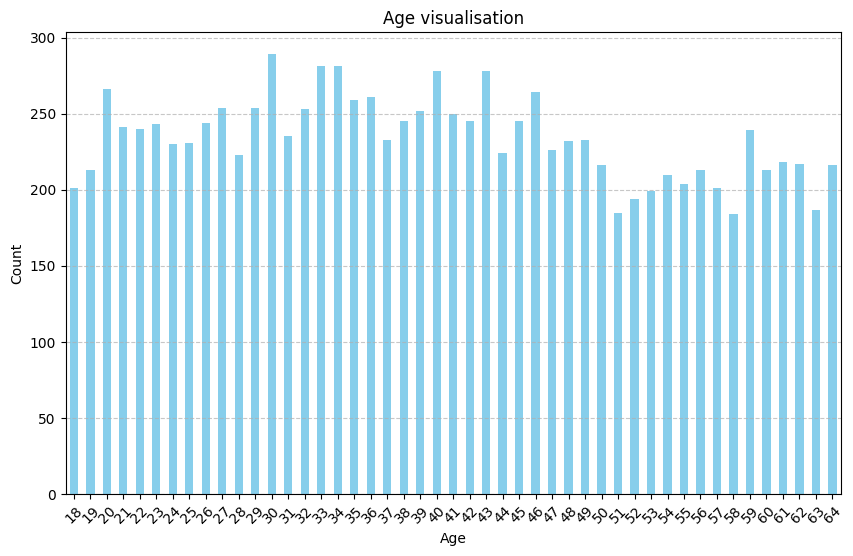

In [6]:
age_counts = data['Age'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar', color='skyblue')
plt.title('Age visualisation')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


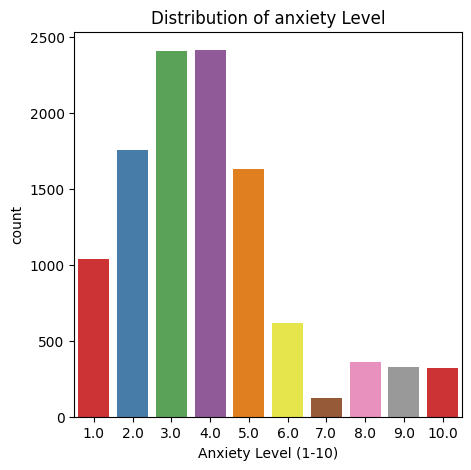

In [7]:
plt.figure(figsize=(5,5))
sns.countplot(x=data["Anxiety Level (1-10)"], palette="Set1")
plt.title("Distribution of anxiety Level")
plt.show()

There is a strong imbalance visible here.

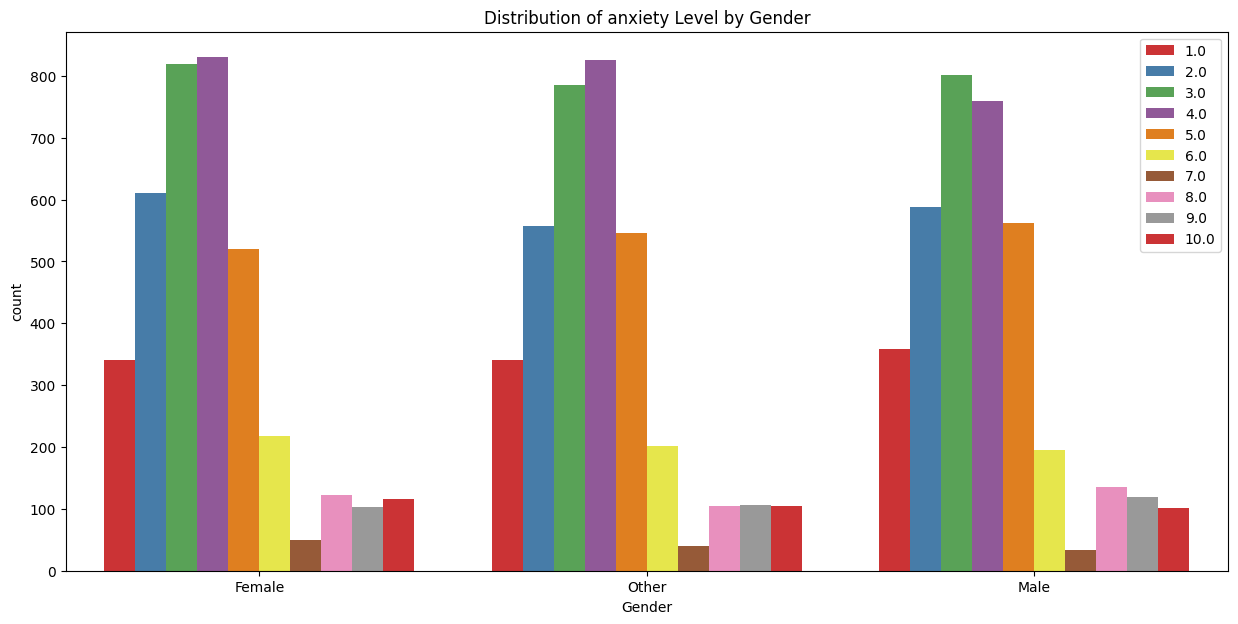

In [8]:
plt.figure(figsize=(15, 7))
sns.countplot(data=data, x='Gender', hue='Anxiety Level (1-10)', palette='Set1')
plt.title("Distribution of anxiety Level by Gender")
plt.legend()
plt.show()

In [9]:
data.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


Removing categorical values to build a correlation matrix.

In [10]:
objects = ['Gender', 'Occupation', 'Smoking', 'Family History of Anxiety', 'Dizziness', 'Recent Major Life Event', 'Medication']
df = data.drop(objects, axis=1)

df.head()

,Age,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Therapy Sessions (per month),Diet Quality (1-10),Anxiety Level (1-10)
0,29,6.0,2.7,181,10,10,114,14,4,3,7,5.0
1,46,6.2,5.7,200,8,1,62,23,2,2,8,3.0
2,64,5.0,3.7,117,4,1,91,28,3,1,1,1.0
3,20,5.8,2.8,360,6,4,86,17,3,0,1,2.0
4,49,8.2,2.3,247,4,1,98,19,4,1,3,1.0


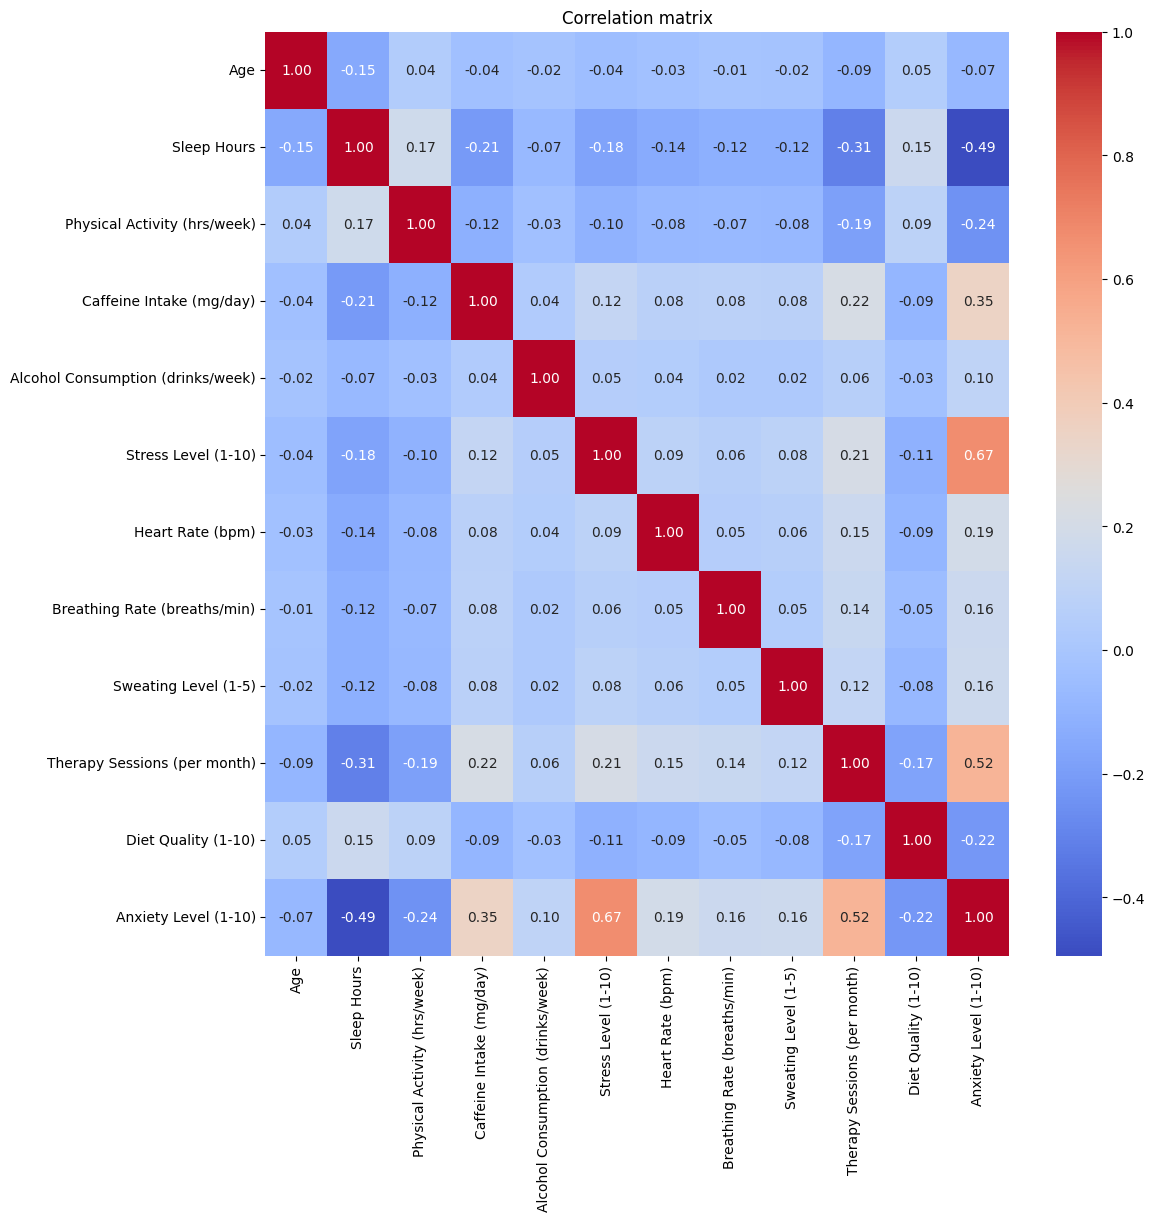

In [11]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()

# Encoder *get_dummies*

The values of the columns *'Gender*' and *'Occupation'* affect the value of "social anxiety", so I use the method **get_dummies**.

In [ ]:
data_dum = pd.get_dummies(data, columns = ['Gender', 'Occupation'])

data_dum

In [ ]:
for column in data_dum.columns:
    if column == 'Anxiety Level (1-10)':
        data_dum[column] = data_dum[column].astype(int)

data_dum

Shifting the anxiety level by -1, since the classifier only works with values starting with 0.

In [ ]:
for column in data_dum.columns:
    if column == 'Anxiety Level (1-10)':
        data_dum[column] = data_dum[column]-1

data_dum

# Label Encoder

In [ ]:
label_encoder = LabelEncoder()

for column in data_dum.columns:
    if data_dum[column].dtype == 'object':
        data_dum[column] = label_encoder.fit_transform(data_dum[column])

data_dum

In [ ]:
for column in data_dum.columns:
    if data_dum[column].dtype == 'bool':
        data_dum[column] = data_dum[column].astype(int)

data_dum

In [ ]:
target = "Anxiety Level (1-10)"

X = data_dum.drop(target, axis=1)
y = data_dum[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Classifier

Automatic hyperparameter selection

In [19]:
model_class = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=10, 
    random_state=42,
    n_jobs=-1
)

params = {
    "colsample_bytree": uniform(0.6, 0.4),  
    "gamma": uniform(0, 0.5),              
    "learning_rate": uniform(0.03, 0.3),    
    "max_depth": randint(2, 6),             
    "n_estimators": randint(100, 150),      
    "subsample": uniform(0.6, 0.4),         
    "reg_alpha": uniform(0, 1),           
    "reg_lambda": uniform(0, 1)            
}

search = RandomizedSearchCV(
    model_class,
    param_distributions=params,
    n_iter=200,              
    cv=3,                     
    scoring="accuracy",       
    verbose=1,
    random_state=42,
    n_jobs=-1                
)

search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best accuracy:", search.best_score_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'colsample_bytree': 0.919942102378926, 'gamma': 0.21260675223461672, 'learning_rate': 0.03674079249603522, 'max_depth': 3, 'n_estimators': 108, 'reg_alpha': 0.5416342146608669, 'reg_lambda': 0.6334782198261473, 'subsample': 0.7031550741732809}
Best accuracy: 0.36306915957559466


In [20]:
best_params = {
    'colsample_bytree': 0.919942102378926, 
    'gamma': 0.21260675223461672, 
    'learning_rate': 0.03674079249603522, 
    'max_depth': 3, 
    'n_estimators': 108, 
    'reg_alpha': 0.5416342146608669, 
    'reg_lambda': 0.6334782198261473, 
    'subsample': 0.7031550741732809
}

final_model_class = xgb.XGBClassifier(
    objective="multi:softmax",
    **best_params,  
    random_state=42,
    n_jobs=-1
)

final_model_class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.919942102378926, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.21260675223461672,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03674079249603522,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=108, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [21]:
y_pred_c = final_model_class.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_c)

print("Accuracy:", accuracy)

Accuracy: 0.34136363636363637


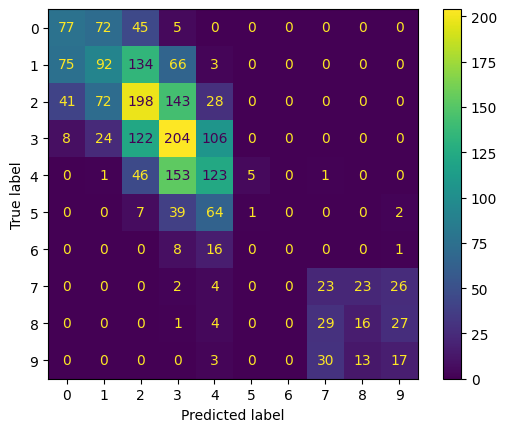

In [22]:
cm = confusion_matrix(y_test, y_pred_c)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# XGBoost Ragression

Automatic hyperparameter selection

In [23]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb
import numpy as np

model_reg = xgb.XGBRegressor(
    objective="reg:squaredlogerror",  
    random_state=42,
    n_jobs=-1
)

params = {
    "colsample_bytree": uniform(0.6, 0.4), 
    "gamma": uniform(0, 0.5),               
    "learning_rate": uniform(0.03, 0.3),    
    "max_depth": randint(2, 6),             
    "n_estimators": randint(100, 150),     
    "subsample": uniform(0.6, 0.4),         
    "reg_alpha": uniform(0, 1),             
    "reg_lambda": uniform(0, 1)            
}

search = RandomizedSearchCV(
    model_reg, 
    param_distributions=params,
    n_iter=200,
    cv=3,
    scoring="neg_mean_squared_error",  
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best MSE:", -search.best_score_)  

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'colsample_bytree': 0.7874772639179881, 'gamma': 0.2074097511688326, 'learning_rate': 0.11202212157921186, 'max_depth': 5, 'n_estimators': 105, 'reg_alpha': 0.691714397168912, 'reg_lambda': 0.5343462750294631, 'subsample': 0.8999642997879886}
Best MSE: 1.0931710287240237


In [24]:
best_params = {
    'colsample_bytree': 0.7874772639179881,
    'gamma': 0.2074097511688326,
    'learning_rate': 0.11202212157921186,
    'max_depth': 5, 
    'n_estimators': 105,
    'reg_alpha': 0.691714397168912, 
    'reg_lambda': 0.5343462750294631, 
    'subsample': 0.8999642997879886
}

final_model_reg = xgb.XGBRegressor(
    objective="reg:squaredlogerror",
    **best_params,  
    random_state=42,
    n_jobs=-1
)

final_model_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7874772639179881, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.2074097511688326,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11202212157921186,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=105, n_jobs=-1,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

In [25]:
y_pred_reg = final_model_reg.predict(X_test)
y_pred_reg

array([4.027899 , 3.7843637, 7.2620177, ..., 2.2856035, 2.4404356,
       2.5574076], dtype=float32)

In [26]:
y_pred_round = np.round(y_pred_reg).astype(int)
y_pred_round

array([4, 4, 7, ..., 2, 2, 3])

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score

mse = mean_squared_error(y_test, y_pred_round)
mae = mean_absolute_error(y_test, y_pred_round)
r2 = r2_score(y_test, y_pred_round)
accuracy = accuracy_score(y_test, y_pred_round)

print("MSE:", mse)
print("MAE:", mae)
print("R²:", r2)
print("Accuracy:", accuracy)

MSE: 1.1154545454545455
MAE: 0.7836363636363637
R²: 0.7592723486382755
Accuracy: 0.3668181818181818


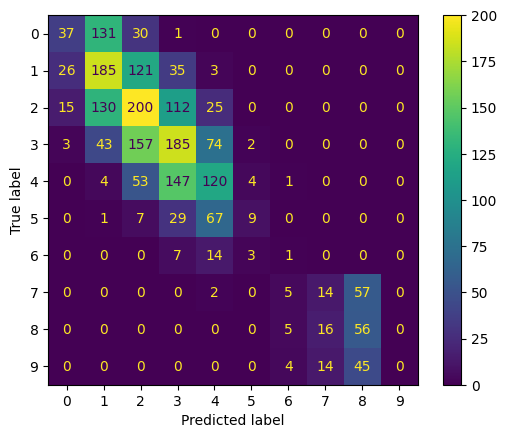

In [28]:
cm = confusion_matrix(y_test, y_pred_round)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [29]:
data_pred={
    'y_pred': y_pred_reg,
    'y_true': y_test,
    'y_fin': y_pred_round
}

df_check = pd.DataFrame(data_pred)
df_check.head(20)

,y_pred,y_true,y_fin
107,4.027899,4,4
5484,3.784364,4,4
6998,7.262018,9,7
3984,0.534632,0,1
3111,1.340344,0,1
4040,0.277686,2,0
3013,3.930634,3,4
6607,2.066857,4,2
4219,2.029302,3,2
8750,2.922791,3,3


In [30]:
df_check.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2200 entries, 107 to 7571
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_pred  2200 non-null   float32
 1   y_true  2200 non-null   int64  
 2   y_fin   2200 non-null   int64  
dtypes: float32(1), int64(2)
memory usage: 60.2 KB


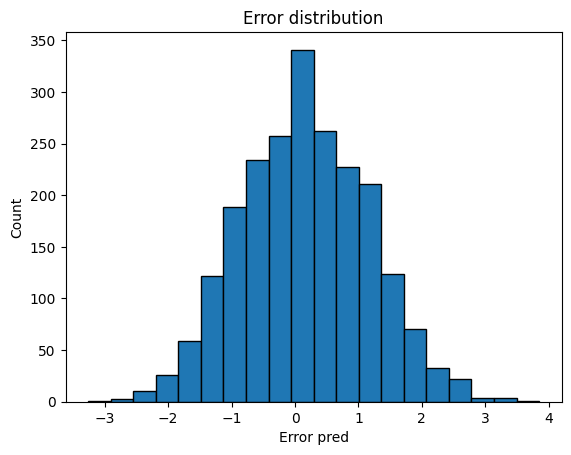

In [31]:
errors = df_check['y_true'] - df_check['y_pred']
plt.hist(errors, bins=20, edgecolor='black')
plt.xlabel("Error pred")
plt.ylabel("Count")
plt.title("Error distribution")
plt.show()

# Second variant anxiety levels

In [32]:
data_dum['Anxiety Level (1-10)'].unique()

array([4, 2, 0, 1, 3, 8, 6, 7, 5, 9])

In [33]:
df_copy = data_dum.copy()  
df_copy['Anxiety Level (1-10)'] = df_copy['Anxiety Level (1-10)'].apply(
    lambda x: 0 if 0 <= x <= 4 else (1 if 5 <= x <= 9 else x)
)
df_copy = df_copy.rename(columns={'Anxiety Level (1-10)': 'Anxiety Level (0-1)'})
df_copy['Anxiety Level (0-1)'].unique()

array([0, 1])

In [34]:
target = "Anxiety Level (0-1)"

X = df_copy.drop(target, axis=1)
y = df_copy[target]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Regression

In [36]:
model_reg = xgb.XGBRegressor(
    objective="reg:squaredlogerror",  
    random_state=42,
    n_jobs=-1
)

params = {
    "colsample_bytree": uniform(0.6, 0.4), 
    "gamma": uniform(0, 0.5),               
    "learning_rate": uniform(0.03, 0.3),    
    "max_depth": randint(2, 6),             
    "n_estimators": randint(100, 150),     
    "subsample": uniform(0.6, 0.4),         
    "reg_alpha": uniform(0, 1),             
    "reg_lambda": uniform(0, 1)            
}

search = RandomizedSearchCV(
    model_reg, 
    param_distributions=params,
    n_iter=200,
    cv=3,
    scoring="neg_mean_squared_error",  
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best MSE:", -search.best_score_)  

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'colsample_bytree': 0.6636982953117058, 'gamma': 0.1018506246381371, 'learning_rate': 0.057349347121857505, 'max_depth': 5, 'n_estimators': 114, 'reg_alpha': 0.45369363460528267, 'reg_lambda': 0.5303543937282561, 'subsample': 0.6071447569913277}
Best MSE: 0.05643844939875306


In [37]:
best_params = {
    'colsample_bytree': 0.6636982953117058, 
    'gamma': 0.1018506246381371, 
    'learning_rate': 0.057349347121857505, 
    'max_depth': 5, 
    'n_estimators': 114, 
    'reg_alpha': 0.45369363460528267,
    'reg_lambda': 0.5303543937282561, 
    'subsample': 0.6071447569913277
}

final_model_reg = xgb.XGBRegressor(
    objective="reg:squaredlogerror",
    **best_params,  
    random_state=42,
    n_jobs=-1
)

final_model_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6636982953117058, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1018506246381371,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.057349347121857505,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=114, n_jobs=-1,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

In [38]:
y_pred_reg = final_model_reg.predict(X_test)
y_pred_reg

array([0.3370105 , 0.1779231 , 0.8827666 , ..., 0.00468401, 0.01781929,
       0.0273743 ], dtype=float32)

In [39]:
y_pred_round = np.round(y_pred_reg).astype(int)
y_pred_round

array([0, 0, 1, ..., 0, 0, 0])

In [40]:
mse = mean_squared_error(y_test, y_pred_round)
mae = mean_absolute_error(y_test, y_pred_round)
r2 = r2_score(y_test, y_pred_round)
accuracy = accuracy_score(y_test, y_pred_round)

print("MSE:", mse)
print("MAE:", mae)
print("R²:", r2)
print("Accuracy:", accuracy)

MSE: 0.06318181818181819
MAE: 0.06318181818181819
R²: 0.5341709522532843
Accuracy: 0.9368181818181818


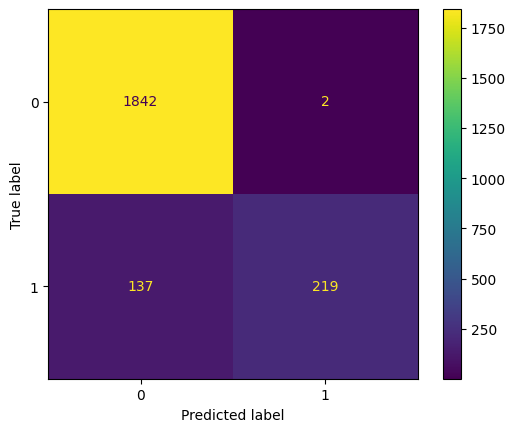

In [41]:
cm = confusion_matrix(y_test, y_pred_round)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()